[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/baloghartur3/speaker-recognition/blob/main/Big_Homework.ipynb)

In [42]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
cwd = os.getcwd()
from scipy import signal
from scipy.io import wavfile
import math, random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from glob import glob
import soundfile
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [43]:
'''
#for audioextract in folders (Not every folder ahs the same amount of audio)
import wave, os, glob
zero = []
path = '/path/to/directory'
for filename in glob.glob(os.path.join(path, '*.wav')):
    w = wave.open(filename, 'r')
    d = w.readframes(w.getnframes())
    zero.append(d)
    w.close()
'''
#df.iloc[1]['relative_path'] this is how to index data!
#EVERY AUDIO HAS 1 CHANNEL
#EVEREY AUDIO HAS has a sampling rate of 16000


data = pd.read_csv("vox1_meta.csv")

col_list = ["VoxCeleb1 ID", "VGGFace1 ID"]
data = pd.read_csv("vox1_meta.csv", usecols=col_list,sep='\t')
df = data.copy()
df['relative_path'] ='wav\\' + df['VoxCeleb1 ID'].astype(str) + '\\'
df['name'] = df['VGGFace1 ID']
df = df[['relative_path', 'name']]
df

,relative_path,name
0,wav\id10001\,A.J._Buckley
1,wav\id10002\,A.R._Rahman
2,wav\id10003\,Aamir_Khan
3,wav\id10004\,Aaron_Tveit
4,wav\id10005\,Aaron_Yoo
...,...,...
1246,wav\id11247\,Zachary_Levi
1247,wav\id11248\,Zachary_Quinto
1248,wav\id11249\,Zack_Snyder
1249,wav\id11250\,Zoe_Saldana


Opening audio files

In [81]:
# ----------------------------
# Load an audio file. Return the signal as an array and the sample rate
# ----------------------------
def audio_open(audio_file):
    sr, sig = wavfile.read(audio_file)
    #sig, sr = sf.read(audio_file)
    return (sig, sr)

# ----------------------------
# Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds and get multiple audio slices from aud (num_samples)
# ----------------------------
def pad_trunc(aud, num_samples, max_ms):
    sig, sr = aud
    sig_len = sig.shape[0]
    max_len = sr//1000 * max_ms
    sigs = []
    
    if (sig_len < sr+max_len):
        sig = np.concatenate((sig, sig))
        sig_len = sig.shape[0]
       
    #only in case of test and validation datasets
    if num_samples == 1:
        sigs = sig[sr:sr+max_len]
    #augmentation
    else:
        #calculate the step size
        contNum = int((sig_len-max_len)/(num_samples-1))
        for i in range(0, sig_len, contNum):
            if i == 0:
                sigs.append(sig[:max_len])
            elif len(sig[i:i+max_len])== sr*(max_ms/1000):
                sigs.append(sig[i:i+max_len])

    return (sigs, sr)

#Add noise to data (not used yet)
def manipulate(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [82]:
#ITERATION----------------------------------------------
def iterate(path, wav_paths, spectrograms, classes, class_id):
    count=0
    rootdir = path #df.iloc[0]['relative_path']
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            wav_paths.append(os.path.join(subdir, file))
            classes.append(class_id)
            count+=1
    return count

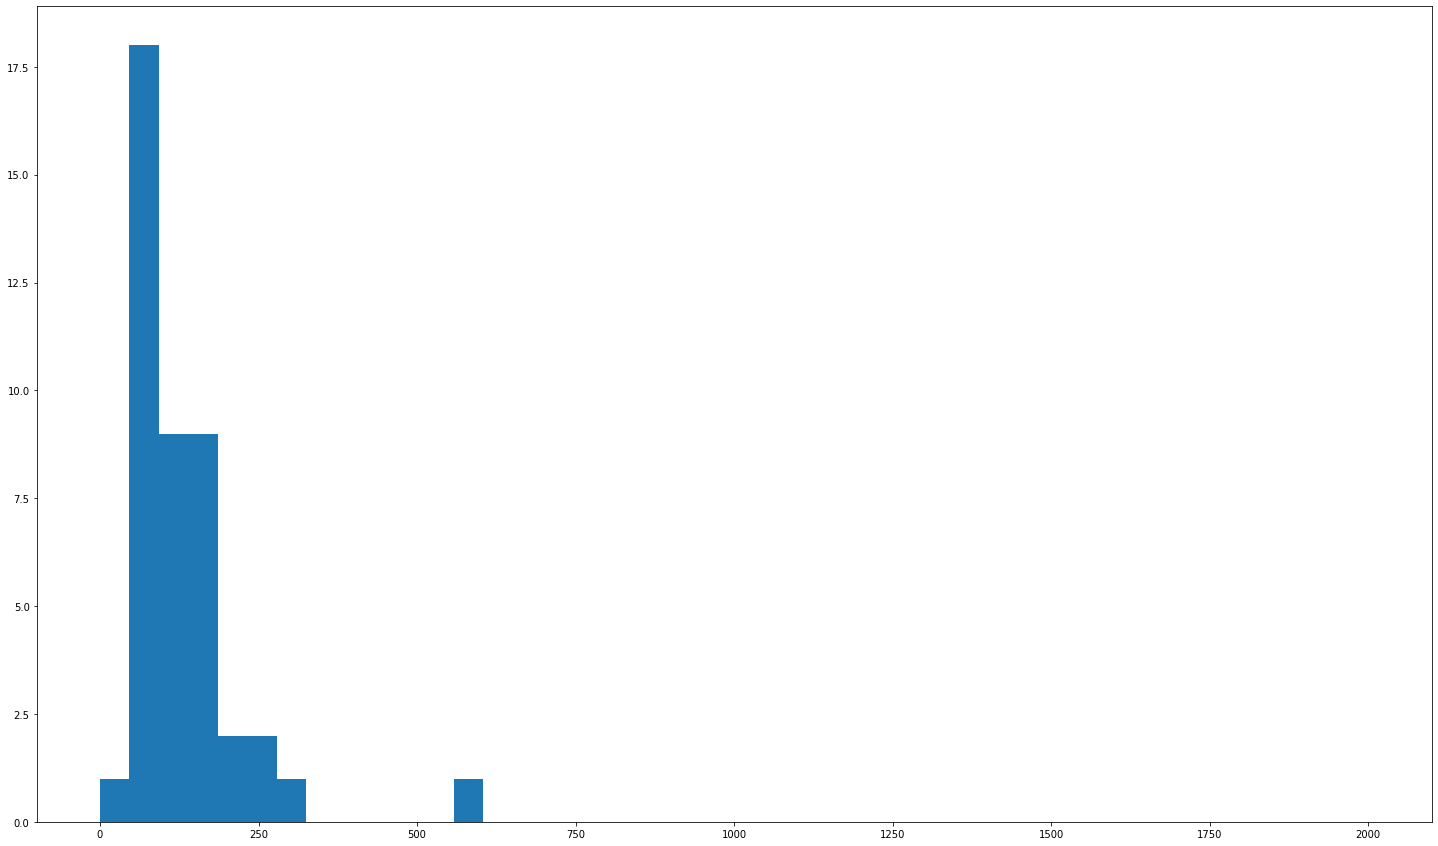

In [126]:
spectrograms = []
wav_paths = []
classes = []
counts=[]
new_class=[]
new_wav_path=[]
num_of_classes=50
for i in range(num_of_classes):
    temp=iterate(df.iloc[i]['relative_path'],wav_paths, spectrograms, classes, i)
    counts.append(temp)
# List to array
spectrograms = np.array(spectrograms)
classes = np.array(classes)
ls=[]
for i in counts:
   if i not in ls:
      ls.append(i)
plt.hist(ls, bins=len(ls), range=(0, 2000))
#Here needs to be a data balancer function...
temp=-1
counter=10000

#Balancing the dataset
for i in range(len(wav_paths)):
    if temp!=classes[i]:
        if counter<(int)(np.average(counts)+30):
            start=i-counter
            end = i-1
            j=0
            while counter < (int)(np.average(counts)+30):
                new_wav_path.append(wav_paths[start+j])
                new_class.append(classes[start+j])
                j+=1
                if start+j+1 >end:
                    j=0
                counter += 1
        temp=classes[i]
        counter=0
    if counter<(int)(np.average(counts)+30):
        new_wav_path.append(wav_paths[i])
        new_class.append(classes[i])
        counter+=1
counter=0
temp=-1

for i in range(len(new_wav_path)):
    if temp!=new_class[i]:
        temp=new_class[i]
        counter=0
    counter+=1

# Separation of train, test and validation data
wav_train, wav_test, label_train, label_test = train_test_split(new_wav_path, new_class, test_size=0.1)
wav_train, wav_val, label_train, label_val = train_test_split(wav_train, label_train, test_size=0.22)

In [100]:
#the length of an audio data
dt = 3
# we process one audio file to get the input dimensions
aud = audio_open(wav_train[0])
aud, sr = pad_trunc(aud, 8, dt*1000)
#generating spectogram
freq, time, spec = signal.spectrogram(aud[0], sr)
spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
#getting the input dimension for the model
dim = spec.shape

In [101]:
def get_sample_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=dim))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [105]:
class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes, scaler, augmentation_size=4,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.augmentation_size= augmentation_size
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor((len(self.wav_paths)*self.augmentation_size) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*(self.batch_size//self.augmentation_size):(index+1)*(self.batch_size//self.augmentation_size)]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]
        
        # generate a batch of time data
        X = np.empty((self.batch_size,dim[0],dim[1], 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        p = 0
        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            aud = audio_open(path)
            aud, sr = pad_trunc(aud,self.augmentation_size, self.dt*1000)
            #rate, wav = wavfile.read(path)
            for k in range(self.augmentation_size):
                #aud[k]= aud[k]*random.randrange(0, 70) #np.multiply(aud[k], random.randrange(50, 100)/100, out=aud[k], casting='unsafe')#random.randrange(50, 100)/100
                freq, time, spec = signal.spectrogram(aud[k], sr)
                spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
                X[p,] = spec
                Y[p,] = to_categorical(label, num_classes=self.n_classes)
                p += 1
       
        X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) 
        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [106]:
class ValDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes, scaler,
                 batch_size=1, shuffle=False):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = False
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor((len(self.wav_paths)) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*(self.batch_size):(index+1)*(self.batch_size)]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]
        
        # generate a batch of time data
        ## itt meg kell adni a spektrogram méretet  -TODO
        X = np.empty((self.batch_size, dim[0],dim[1], 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        #itt kell spektrogrammá alakítani és augmentálni -TODO
        p = 0
        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            aud = audio_open(path)
            #rate, wav = wavfile.read(path)
            aud, sr = pad_trunc(aud, 1, dt*1000)
            freq, time, spec = signal.spectrogram(aud, sr)
            spec = np.reshape(spec, (spec.shape[0], spec.shape[1], 1))
            X[p,] = spec
            Y[p,] = to_categorical(label, num_classes=self.n_classes)
            p += 1
        
        X = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) #TODO csak a traint transform!
        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [107]:
#Standardization
scaler = preprocessing.StandardScaler()

tg = TrainDataGenerator(wav_train, label_train, sr, dt,
                       num_of_classes,augmentation_size=8, scaler=scaler, batch_size=32)
vg = ValDataGenerator(wav_val, label_val, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=32)
testg = ValDataGenerator(wav_test, label_test, sr, dt,
                       num_of_classes, scaler=scaler, batch_size=1)

In [108]:
#initialize model
model=get_sample_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 129, 214, 32)      320       
_________________________________________________________________
activation_28 (Activation)   (None, 129, 214, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 127, 212, 64)      18496     
_________________________________________________________________
activation_29 (Activation)   (None, 127, 212, 64)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 106, 64)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 63, 106, 64)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 63, 106, 64)      

In [109]:
#Adding callback functions
callback = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='BestModel.hdf5', save_best_only=True, verbose=1)
#Model training
model.fit(tg, validation_data=vg,callbacks=[checkpoint, callback],
              epochs=100, verbose=1)

Epoch 1/100
1353/1353 [==============================] - 206s 152ms/step - loss: 3.8958 - accuracy: 0.0288 - val_loss: 3.7633 - val_accuracy: 0.0552

Epoch 00001: val_loss improved from inf to 3.76335, saving model to BestModel.hdf5
Epoch 2/100
1353/1353 [==============================] - 206s 152ms/step - loss: 3.4336 - accuracy: 0.1050 - val_loss: 3.0020 - val_accuracy: 0.1941

Epoch 00002: val_loss improved from 3.76335 to 3.00203, saving model to BestModel.hdf5
Epoch 3/100
1353/1353 [==============================] - 204s 151ms/step - loss: 2.8080 - accuracy: 0.2167 - val_loss: 2.3611 - val_accuracy: 0.3358

Epoch 00003: val_loss improved from 3.00203 to 2.36109, saving model to BestModel.hdf5
Epoch 4/100
1353/1353 [==============================] - 201s 149ms/step - loss: 2.4600 - accuracy: 0.2947 - val_loss: 2.2589 - val_accuracy: 0.3876

Epoch 00004: val_loss improved from 2.36109 to 2.25890, saving model to BestModel.hdf5
Epoch 5/100
1353/1353 [==============================] -

In [113]:
#Output decoding
def label_to_name(label):
    return df.iloc[label]['name']

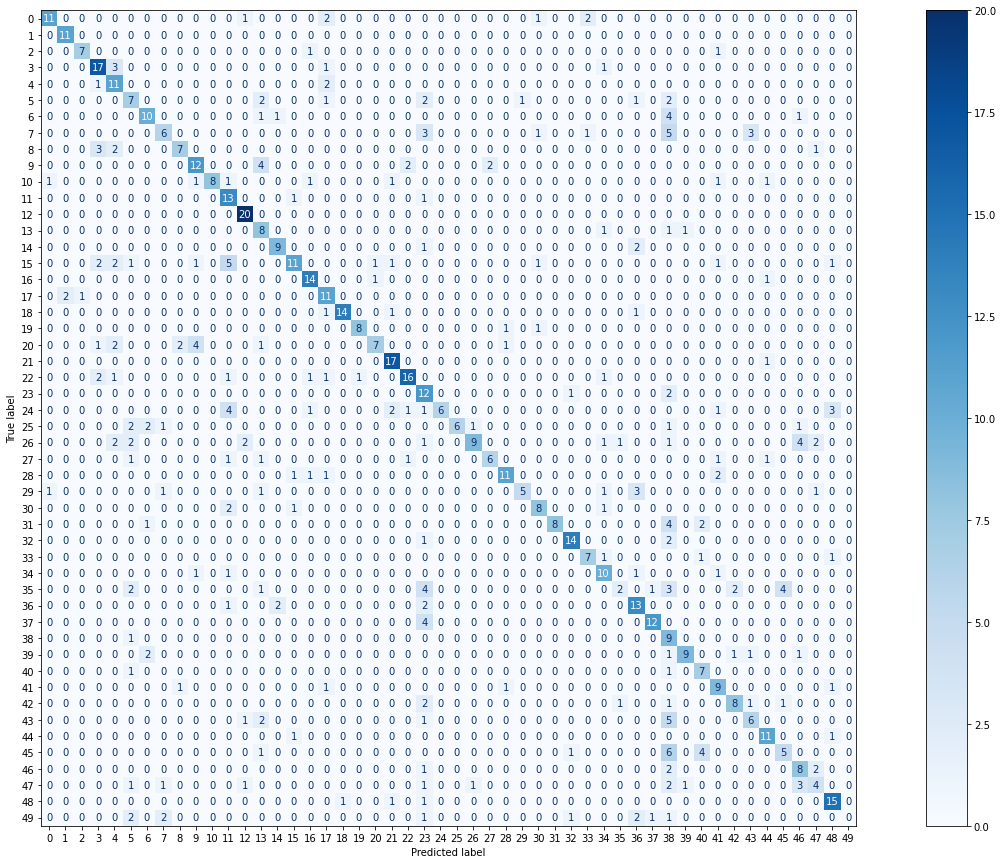

In [122]:
#Loading the best model
model = load_model('BestModel.hdf5')
#prediction
predictions = np.argmax(model.predict(testg), axis=-1)
#Visualization
c_matrix = confusion_matrix(label_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
plt.rcParams['figure.figsize'] = [25, 15]
disp.plot(cmap=plt.cm.Blues)
plt.show()
acc = accuracy_score(label_test, predictions)

In [123]:
#Show a few results
for i in range(10):
    print("A vart eredmeny: " , label_to_name(label_test[i]))
    print("A kapott: " , label_to_name(predictions[i]))
print("Accuracy: {:.2f}%".format((acc*100)))

A vart eredmeny:  Adam_Driver
A kapott:  Adam_Driver
A vart eredmeny:  Alison_Arngrim
A kapott:  Alba_Rohrwacher
A vart eredmeny:  Andrea_Riseborough
A kapott:  Alison_Arngrim
A vart eredmeny:  Abigail_Spencer
A kapott:  America_Ferrera
A vart eredmeny:  Alison_Pill
A kapott:  Alison_Pill
A vart eredmeny:  Abigail_Breslin
A kapott:  Alison_Pill
A vart eredmeny:  Abigail_Spencer
A kapott:  Abigail_Spencer
A vart eredmeny:  Alan_Tudyk
A kapott:  Alan_Tudyk
A vart eredmeny:  Alexandra_Roach
A kapott:  Alexandra_Roach
A vart eredmeny:  Alex_Kingston
A kapott:  Adrianne_Curry
Accuracy: 61.53%


In [89]:
#To clear GPU memory in case of error
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

In [2]:
#import gc
#gc.collect()

5